# Exploring SPMV

First, include some libraries

In [95]:
# Run boilerplate code to set up environment

%run prelude.py

Prelude loaded OK


## Preprocessing Graph

In [152]:
#
# Function to take a 2D tensor (i.e. an adjacenc matrix) as input and generate a CSF as output
#


def create_CSF():
    


## Graph Inputs

In [158]:
#
# Function to create graph inputs
#


# Create inputs based on the slides that Aamer used to do the initial SPMV mapping on Symphony
def create_inputs(display=True):
    
    # Adjacency matrix - Ranks "S" (source) and "D" (destination)

    adjMat = Tensor.fromUncompressed([ "S", "D"],
                                [ [ 0, 1, 0, 0, 1, 1, 1, 0 ],
                                  [ 1, 0, 0, 1, 1, 1, 0, 0 ],
                                  [ 0, 0, 0, 0, 0, 0, 0, 0 ],
                                  [ 0, 1, 0, 0, 1, 0, 1, 0 ],
                                  [ 1, 1, 0, 1, 0, 1, 0, 1 ],
                                  [ 1, 1, 0, 0, 1, 0, 0, 1 ],
                                  [ 1, 0, 0, 1, 0, 0, 0, 0 ],
                                  [ 0, 0, 0, 0, 1, 1, 0, 0 ] ])

    # Vector
    srcData = Tensor.fromUncompressed([ "V" ], [ 1, 1, 1, 1, 1, 1, 1, 1 ])

    # Vector
    dstData = Tensor(rank_ids=["V"])
    
    print("Created Adjacency Matrix")
    if display:
        displayTensor(adjMat)

    print("Created SrcData")
    if display:
        displayTensor(srcData)

    print("Created DstData")
    if display:
        displayTensor(dstData)

    return (dstData, adjMat, srcData)



# Naive SPMV - source stationary (push)

This version traverses all neighbors of each source node.

In [155]:
# Create inputs
(dstData, adjMat, srcData) = create_inputs(False)

# Get root fibers
adjMat_s  = adjMat.getRoot()
srcData_v = srcData.getRoot()
dstData_v = dstData.getRoot()

#print("Displaying Graph")
#displayGraph(adjMat_s)

#print("Displaying Fiber Tree Representation of Adjacency Matrix")
#displayTensor(adjMat)

#print("Displaying Fiber Tree Representation of Vector")
#displayTensor(srcData)

# create a tensor frame
canvas = TensorCanvas(adjMat, srcData, dstData)

# Perform the src stationary SPMV
print("Running SRC stationary SPMV:")

for s, (adjMat_d, srcData_val) in (adjMat_s & srcData_v):
    for d, (dstData_ref, adjMat_val), in (dstData_v << adjMat_d):
        dstData_ref += adjMat_val * srcData_val
        canvas.addFrame([s,d], [s], [d])

# display the canvas animation
displayCanvas(canvas)



Created Adjacency Matrix
Created Vector
Created Output
Running SRC stationary SPMV:


# Naive SPMV - destination stationary (pull)

This version traverses all neighbors of each destination node.

In [160]:
# Create inputs

(dstData, adjMat, srcData) = create_inputs(False)

# Get root fibers
adjMat_s  = adjMat.getRoot()
srcData_v = srcData.getRoot()
dstData_v = dstData.getRoot()

#print("Displaying Graph")
#displayGraph(adjMat_s)

# For destination stationary we need to swap the matrix
adjMat_transpose_d = adjMat_s.swapRanks();

#print("Displaying Transposed Graph")
#displayGraph(adjMat_transpose_d)

# create the actual transposed tensor in memory 
print("Creating Transpose of Typical Adjacency Matrix to Perform Dst Stationary Traversal:")
adjMat_transposed = Tensor.fromFiber(["D", "S"], adjMat_transpose_d)

#print("Displaying Fiber Tree Representation of Transposed Adjacency Matrix")
#displayTensor(adjMat_transposed)

#print("Displaying Fiber Tree Representation of srcData")
#displayTensor(srcData)

#print("Displaying Fiber Tree Representation of dstData")
#displayTensor(dstData)

# create the new canvas with transposed adjacency matrix
canvas = TensorCanvas(adjMat_transposed, srcData, dstData)

# Perform the dst stationary SPMV
print("Running DST stationary SPMV:")

# Perform the destination stationary SPMV
for d, (dstData_ref, adjMat_transpose_s) in (dstData_v << adjMat_transpose_d):
    for s, (adjMat_transpose_val, srcData_val), in (adjMat_transpose_s & srcData_v):
        dstData_ref += adjMat_transpose_val * srcData_val
        canvas.addFrame([d,s], [s], [d])

# display the canvas animation
displayCanvas(canvas)



Created Adjacency Matrix
Created SrcData
Created DstData
Creating Transpose of Typical Adjacency Matrix to Perform Dst Stationary Traversal:
Running DST stationary SPMV:


# 1D -- Spatially Tiled SPMV - src stationary (push)

This version traverses all neighbors of each source node.

In [162]:
# Create inputs
(dstData, adjMat, srcData) = create_inputs(False)

# Get root fibers
adjMat_s  = adjMat.getRoot()
srcData_v = srcData.getRoot()
dstData_v = dstData.getRoot()

# Tile the adjacency matrix in the source dimension 
print("Tiling the adjacency matrix in coordinate space uniformly with tile size=2")
adjMat_tiled_s1 = adjMat_s.splitUniform(2)
#displayTensor(adjMat_tiled_s1)

# Tile the srcData vector in the source dimension 
print("Tiling the srcData vector in coordinate space uniformly with tile size=2")
srcData_tiled_v1 = srcData_v.splitUniform(2)
#displayTensor(srcData_tiled_v1)

# create a tensor frame
canvas = TensorCanvas(adjMat_tiled_s1, srcData_tiled_v1, dstData)

# Perform the src stationary SPMV
print("Running Tiled SRC stationary SPMV:")

# perform the tiled src stationary SPMV
for s1, (adjMat_tiled_s0, srcData_tiled_v0) in (adjMat_tiled_s1 & srcData_tiled_v1):
    for s0, (adjMat_tiled_d, srcData_tiled_val) in (adjMat_tiled_s0 & srcData_tiled_v0):
        for d, (dstData_ref, adjMat_tiled_val) in (dstData_v << adjMat_tiled_d):
            dstData_ref += adjMat_tiled_val * srcData_tiled_val
            canvas.addFrame([s1,s0,d], [s1,s0], [d])

# display the canvas animation
displayCanvas(canvas)


Created Adjacency Matrix
Created SrcData
Created DstData
Tiling the adjacency matrix in coordinate space uniformly with tile size=2
Tiling the srcData vector in coordinate space uniformly with tile size=2
Running Tiled SRC stationary SPMV:


# 2D -- Spatially Tiled SPMV - src stationary (push)  -- Work In Progress

This version traverses all neighbors of each source node.

Created Adjacency Matrix
Created Vector
Created Output
Tiling the adjacency matrix in coordinate space uniformly with tile size=2


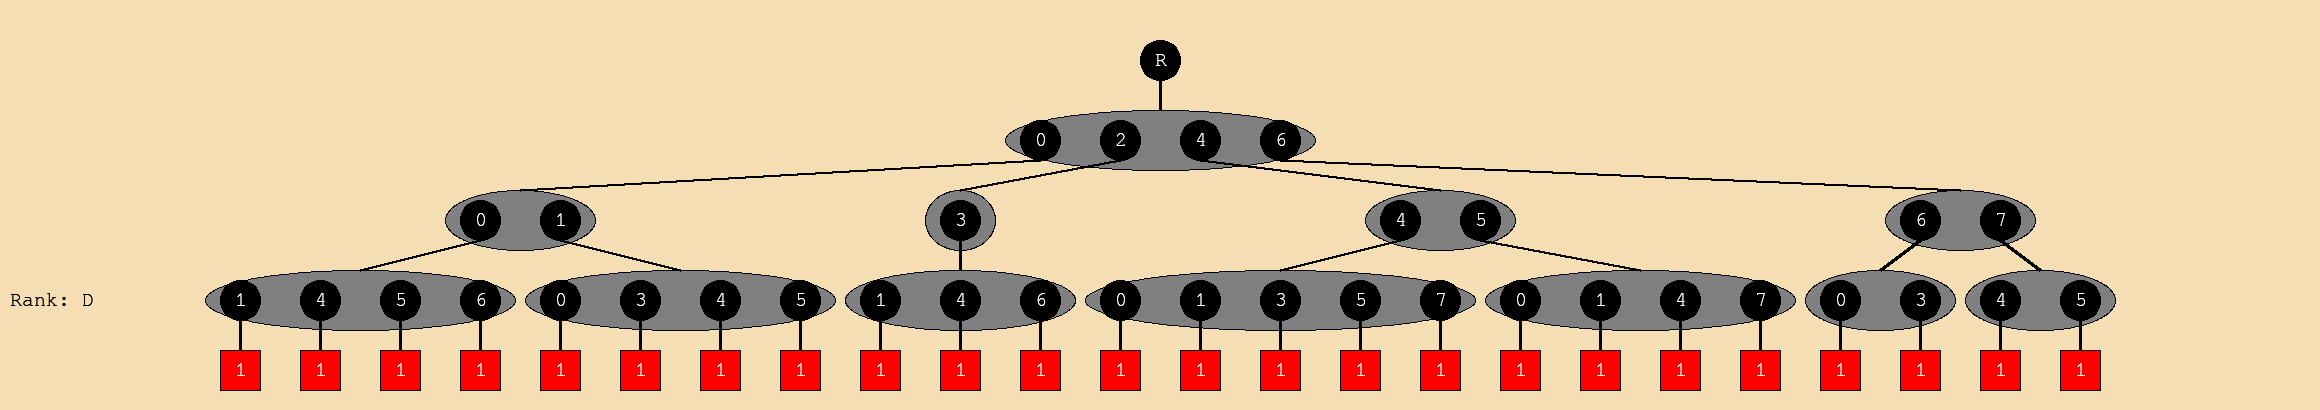

Tiling the srcData vector in coordinate space uniformly with tile size=2


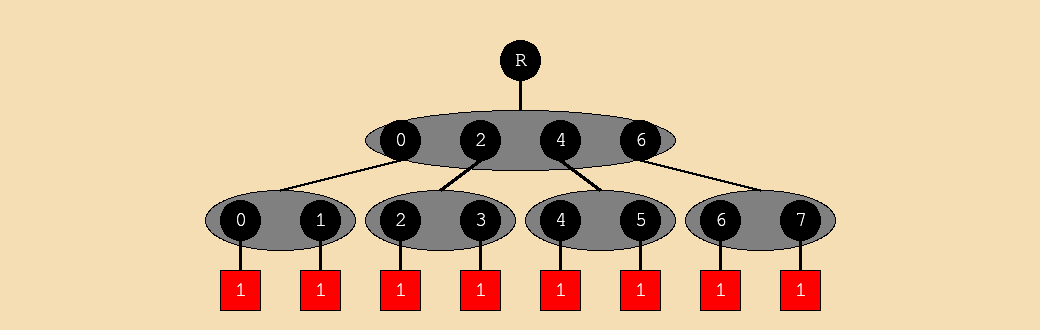

Tiling the dstData vector in coordinate space uniformly with tile size=2


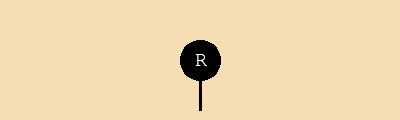

In [151]:
# Create inputs
(dstData, adjMat, srcData) = create_inputs(False)

# Get root fibers
adjMat_s  = adjMat.getRoot()
srcData_v = srcData.getRoot()
dstData_v = dstData.getRoot()

# Tile the adjacency matrix in the source dimension 
print("Tiling the adjacency matrix in coordinate space uniformly with tile size=2")
adjMat_tiled_s1 = adjMat_s.splitUniform(2)

# display the tiled tensor
displayTensor(adjMat_tiled_s1)

# Tile the srcData vector in the src dimension 
print("Tiling the srcData vector in coordinate space uniformly with tile size=2")
srcData_tiled_v1 = srcData_v.splitUniform(2)
displayTensor(srcData_tiled_v1)

# Tile the dstData vector in the dst dimension 
print("Tiling the dstData vector in coordinate space uniformly with tile size=2")
dstData_tiled_v1 = dstData_v.splitUniform(2)
displayTensor(dstData_tiled_v1)

# create a tensor frame
canvas = TensorCanvas(adjMat_tiled_s1, srcData_tiled_v1, dstData)

# perform the tiled src stationary SPMV
for s1, (adjMat_tiled_s0, srcData_tiled_v0) in (adjMat_tiled_s1 & srcData_tiled_v1):
    for s0, (adjMat_tiled_d, srcData_tiled_val) in (adjMat_tiled_s0 & srcData_tiled_v0):
        for d, (dstData_ref, adjMat_tiled_val) in (dstData_v << adjMat_tiled_d):
            dstData_ref += adjMat_tiled_val * srcData_tiled_val
            canvas.addFrame([s1,s0,d], [s1,s0], [d])

# display the canvas animation
displayCanvas(canvas)
